In [1]:
import keras
from keras.preprocessing import image as kimage
from keras.applications import mobilenet_v2, densenet, vgg16, resnet50
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import os
import time
import joblib
from sklearn.neighbors import KDTree

Using TensorFlow backend.


In [2]:
net = resnet50.ResNet50(include_top=False, weights='imagenet', pooling='max')
net2 = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', pooling='avg', input_shape=(224, 224, 3))

In [3]:
detector = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

In [54]:
def rileva_faccia(img):   
    
    img = cv.imread(img)
    b,g,r = cv.split(img)
    img = cv.merge([r,g,b])
    face = 0
    img = cv.resize(img, (224,224))
    #img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = detector.detectMultiScale(img)
    #print(len(faces))
    if len(faces) == 1:
        
        for (x,y,w,h) in faces:
            face = img[y:y+h,x:x+h,:]
        
        face=cv.resize(face, (224,224))
        #plt.imshow(face); plt.show()
    
        return face
    

In [5]:
def neural_features(img):
    #preprocessare ed estrarre le features neurali
    x = kimage.img_to_array(img)
    x = mobilenet_v2.preprocess_input(x) 
    x = np.expand_dims(x, axis=0)
    f = net.predict(x)
    return f.flatten()

In [6]:
def load_data(feature_extractor):
    
    data_path = 'people/'

    paths = []
    labels = []
    features = []
    for subdir in os.listdir(data_path):
        full_path = os.path.join(data_path, subdir)

        for fi,f in enumerate(sorted(os.listdir(full_path))):
            if f.endswith('.jpg') and fi < 500:
                cur_path = full_path + '/' + f
                #print(cur_path)
                face = rileva_faccia(cur_path)
                if type(face)==np.ndarray:
                    cur_features = feature_extractor(face)
                    features.append(cur_features)
                    paths.append(cur_path)
                    labels.append(subdir)
                

    features = np.array(features)
    return features, labels, paths

Comandi per salvare l'albero di ricerca e i path associati alle foto.

In [7]:
%%time
X_train, labels, paths = load_data(neural_features)

Wall time: 14h 41min 5s


In [8]:
tree = KDTree(X_train)

In [9]:
joblib.dump(tree, 'people_tree.joblib')

['people_tree.joblib']

In [10]:
with open('people_labels.txt','w') as lab:
    for i in labels:
        lab.write(i+';')

with open('people_paths.txt','w') as pat:
    for i in paths:
        pat.write(i+';')

Caricare i file da qua:

In [11]:
tree = joblib.load('people_tree.joblib') 

In [12]:
with open('people_labels.txt','r') as labels_read:
    file=labels_read.read()
labels_people=file.split(';')
labels_people=labels_people[:-1]


with open('people_paths.txt','r') as paths_read:
    file=paths_read.read()
paths_people=file.split(';')
paths_people=paths_people[:-1]

In [13]:
def retrieve_top10(query_image, tree):
  
    query_face = rileva_faccia(query_image)
    query_features = neural_features(query_face)
    query_features = np.expand_dims(query_features, axis=0)
    plt.imshow(kimage.load_img(query_image))
    plt.axis('off')
    dists, ind = tree.query(query_features, k=10)
    paths=[paths_people[int(ind[0][i])] for i in range(10)]
    stars=[labels_people[int(ind[0][i])] for i in range(10)]
    dist=dists[0]
    fig = plt.figure(figsize=(20, 30))
    

    columns = 2
    rows = 5
    for n in range(1,len(paths)+1):
        d=dist[n-1]
        dnorm=1-(   (d-min(dist)) / (max(dist)-min(dist)) )
        plt.subplot(rows, columns, n)
        plt.imshow(kimage.load_img(paths[n-1]))
        plt.axis('off')
        
        plt.title(str(stars[n-1])+'\n euclidean dist: '+str(   round(   d,2)  )
                 +'\nrelative dist: '+str(round(dnorm*100,2))+'%')
        plt.grid(False)
    return 'Top-10 most similar faces'

In [ ]:
cap = cv.VideoCapture(0)
time.sleep(3)
result, img = cap.read()
cap.release()

In [51]:
cv.imwrite("foto_test.jpg", img) 

True

'Top-10 most similar faces'

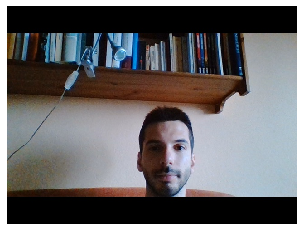

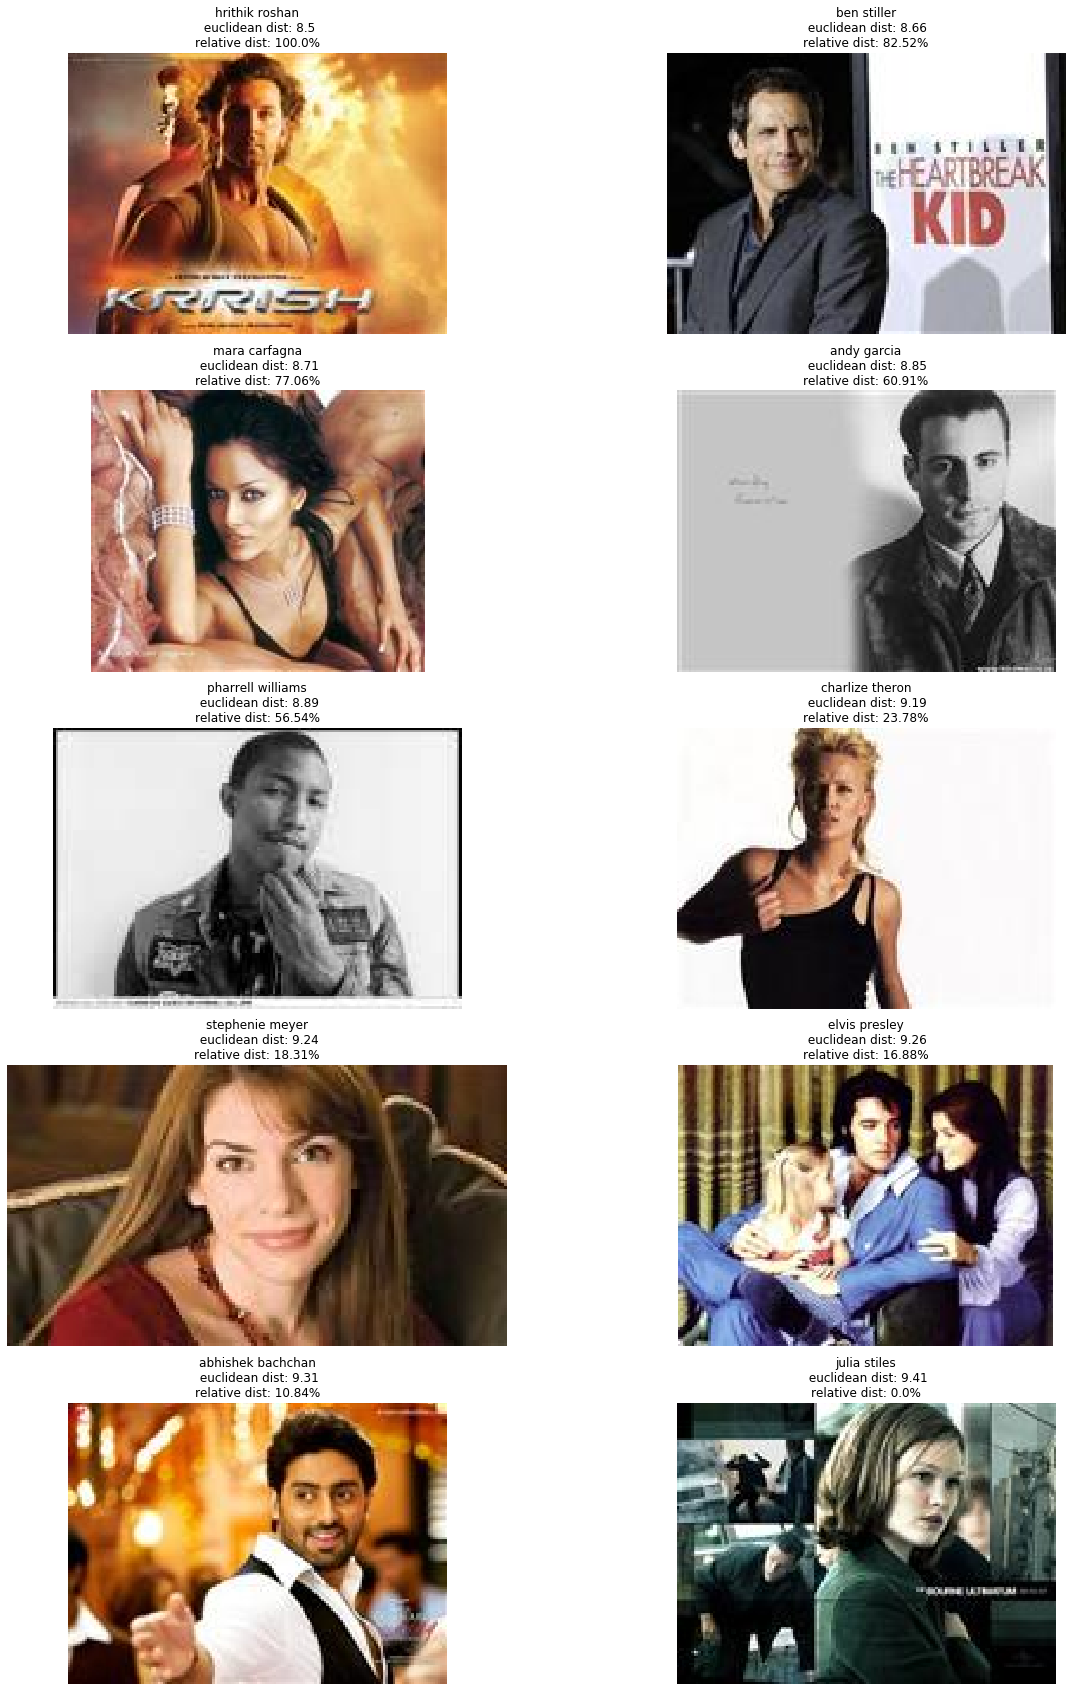

In [55]:
retrieve_top10('foto_test.jpg', tree)